In [2]:
cd ~/datasets

/Users/rich/datasets


In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 100

pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

# Quickstart

We will be working on a mutagenicity dataset, released by [Kazius et al.](http://pubs.acs.org/doi/abs/10.1021/jm040835a).  4337 compounds, provided as the file `mols.sdf`, were subjected to the [AMES test](https://en.wikipedia.org/wiki/Ames_test).  The results are given in `labels.csv`.  We will clean the molecules, perform a brief chemical space  analysis before finally assessing potential predictive models built on the data.

## Imports

**scikit-chem** imports all subpackages with the main package, so all we need to do is import the main package, `skchem`.  We will also need `pandas`.

In [4]:
import skchem
import pandas as pd

## Loading the data

We can use `skchem.read_sdf` to import the sdf file:

In [5]:
ms_raw = skchem.read_sdf('mols.sdf'); ms_raw

batch
1728-95-6     <Mol: COc1ccc(-c2nc(-c3ccccc3)c(-c3ccccc3)[nH]...
91-08-7                            <Mol: Cc1c(N=C=O)cccc1N=C=O>
89786-04-9      <Mol: CC1(Cn2ccnn2)C(C(=O)O)N2C(=O)CC2S1(=O)=O>
2439-35-2                               <Mol: C=CC(=O)OCCN(C)C>
95-94-3                             <Mol: Clc1cc(Cl)c(Cl)cc1Cl>
                                    ...                        
89930-60-9    <Mol: CCCn1cc2c3c(cccc31)C1C=C(C)CN(C)C1C2.O=C...
9002-92-0             <Mol: CCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCO>
90597-22-1               <Mol: Nc1ccn(C2C=C(CO)C(O)C2O)c(=O)n1>
924-43-6                                      <Mol: CCC(C)ON=O>
97534-21-9              <Mol: O=C1NC(=S)NC(=O)C1C(=O)Nc1ccccc1>
Name: structure, dtype: object

And pandas to import the labels.

In [32]:
y_raw = pd.read_csv('labels.csv').set_index('name').squeeze(); y_raw

name
1728-95-6        mutagen
91-08-7          mutagen
89786-04-9    nonmutagen
2439-35-2     nonmutagen
95-94-3       nonmutagen
                 ...    
89930-60-9       mutagen
9002-92-0     nonmutagen
90597-22-1    nonmutagen
924-43-6         mutagen
97534-21-9    nonmutagen
Name: Ames test categorisation, dtype: object

And binarize them:

In [36]:
y_bin = y_raw == 'mutagen'

/Users/rich/anaconda/lib/python3.5/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

Quickly check the class balance:

In [ ]:
y_raw.value_counts().plot.bar()

The classes are (mercifully) quite balanced.

## Cleaning

The data is unlikely to be canonicalized, and potentially contain broken or difficult molecules, so we will now clean it.

### Standardization

The first step is to apply a `Transformer` to canonicalize the representations.  Specifically, we will use the ChemAxon Standardizer wrapper.  Some compounds are likely to fail this procedure, however they are likely to still be valid structures, so we will use the `keep_failed` configuration option on the object to keep these, rather than returning a None, or raising an error.

In [8]:
std = skchem.standardizers.ChemAxonStandardizer(keep_failed=True)

In [9]:
ms = std.transform(ms_raw); ms

ChemAxonStandardizer: 100% (4337 of 4337) |####################################| Elapsed Time: 0:00:32 Time: 0:00:32


batch
1728-95-6     <Mol: COc1ccc(-c2nc(-c3ccccc3)c(-c3ccccc3)[nH]...
91-08-7                            <Mol: Cc1c(N=C=O)cccc1N=C=O>
89786-04-9      <Mol: CC1(Cn2ccnn2)C(C(=O)O)N2C(=O)CC2S1(=O)=O>
2439-35-2                               <Mol: C=CC(=O)OCCN(C)C>
95-94-3                             <Mol: Clc1cc(Cl)c(Cl)cc1Cl>
                                    ...                        
89930-60-9          <Mol: CCCn1cc2c3c(cccc31)C1C=C(C)CN(C)C1C2>
9002-92-0             <Mol: CCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCO>
90597-22-1               <Mol: Nc1ccn(C2C=C(CO)C(O)C2O)c(=O)n1>
924-43-6                                      <Mol: CCC(C)ON=O>
97534-21-9             <Mol: O=C(Nc1ccccc1)c1c(O)nc(=S)[nH]c1O>
Name: structure, dtype: object

### Filter undesirable molecules

Next, we will remove molecules that are likely to not work well with the circular descriptors that we will use.  These are usually *large* or *inorganic* molecules.

To do this, we will use some `Filters`, which implement the `filter` method.

In [10]:
of = skchem.filters.OrganicFilter()

ms, y = of.filter(ms, y)

OrganicFilter: 100% (4337 of 4337) |###########################################| Elapsed Time: 0:00:05 Time: 0:00:05


In [11]:
mf = skchem.filters.MassFilter(above=100, below=900)

ms, y = mf.filter(ms, y)

MassFilter: 100% (4337 of 4337) |##############################################| Elapsed Time: 0:00:00 Time: 0:00:00


In [12]:
nf = skchem.filters.AtomNumberFilter(above=5, below=100, include_hydrogens=True)

ms, y = nf.filter(ms, y)

AtomNumberFilter: 100% (4068 of 4068) |########################################| Elapsed Time: 0:00:00 Time: 0:00:00


### Optimize Geometry

We would like to calculate some features that require three dimensional coordinates, so we will next calculate three dimensional conformers using the Universal Force Field.  Additionally, some compounds may be unfeasible - these should be dropped from the dataset. In order to do this, we will use the `transform_filter` method:

In [13]:
uff = skchem.forcefields.UFF()

ms, y = uff.transform_filter(ms, y)

/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 109883-99-0
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 135768-83-1
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 13366-73-9
  warnings.warn(msg)
UFF: 100% (4046 of 4046) |#####################################################| Elapsed Time: 0:01:47 Time: 0:01:47


In [14]:
len(ms)

4043

As we can see, we get a warning that 3 molecules failed to embed, have been dropped.  If we didn't care about the warnings, we could have set the `warn_on_fail` property to `False` (or set it using a keyword argument at initialization).  Conversely, if we *really* cared about failures, we could have set `error_on_fail` to True, which would raise an Error if any `Mol`s failed to embed.

### Visualize Chemical Space

**scikit-chem** adds a custom `mol` accessor to `pandas.Series`, which provides a shorthand for calling methods on all `Mol`s in the collection.  This is analogous to the `str` accessor:

In [15]:
y_raw.str.get_dummies()

,mutagen,nonmutagen
name,,
1728-95-6,1,0
91-08-7,1,0
89786-04-9,0,1
2439-35-2,0,1
95-94-3,0,1
...,...,...
89930-60-9,1,0
9002-92-0,0,1
90597-22-1,0,1


We will use this function to binarize the labels:

In [16]:
y = y.str.get_dummies()['mutagen']

Amongst other options, it is provides access to chemical space plotting functionality.  This will featurize the molecules using a passed featurizer (or a string shortcut), and a dimensionality reduction technique to reduce the feature space to two dimensions, which are then plotted.  In this example, we use circular Morgan fingerprints, reduced by [t-SNE](https://lvdmaaten.github.io/tsne) to visualize structural diversity in the dataset.

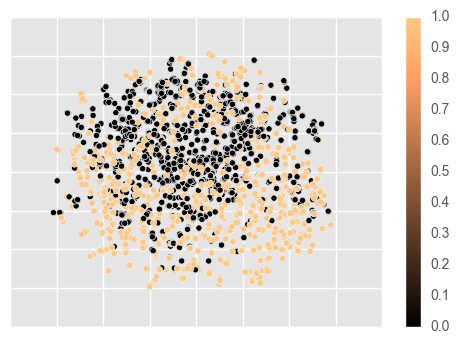

In [17]:
ms.mol.visualize(fper='morgan',
                 dim_red='tsne', dim_red_kw={'method': 'exact'}, 
                 c=y, 
                 cmap='copper')

The data appears to be reasonably separable in structural space, so we may suspect that Morgan fingerprints will be a good representation for modelling the data.

## Featurizing the data

As previously noted, Morgan fingerprints would be a good fit for this data.  To calculate them, we will use the `MorganFeaturizer` class, which is a `Transformer`.

In [18]:
mf = skchem.descriptors.MorganFeaturizer()

X, y = mf.transform(ms, y); X

MorganFeaturizer: 100% (4043 of 4043) |########################################| Elapsed Time: 0:00:01 Time: 0:00:01


morgan_fp_idx,0,1,2,3,4,...,2043,2044,2045,2046,2047
batch,,,,,,,,,,,
1728-95-6,0,0,0,0,0,...,0,0,0,0,0
91-08-7,0,0,0,0,0,...,0,0,0,0,0
89786-04-9,0,0,0,0,0,...,0,0,0,0,0
2439-35-2,0,0,0,0,0,...,0,0,0,0,0
95-94-3,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
89930-60-9,0,0,0,0,0,...,0,0,0,0,0
9002-92-0,0,0,0,0,0,...,1,0,1,0,0
90597-22-1,0,0,0,0,0,...,0,0,0,0,0


## Pipelining

If this process appeared unnecessarily laborious (as it should!), **scikit-chem** provides a `Pipeline` class that will sequentially apply objects passed to it. For this example, we could have simply performed:

In [35]:
pipeline = skchem.pipeline.Pipeline([
        skchem.standardizers.ChemAxonStandardizer(keep_failed=True),
        skchem.forcefields.UFF(),
        skchem.filters.OrganicFilter(),
        skchem.filters.MassFilter(above=100, below=1000),
        skchem.filters.AtomNumberFilter(above=5, below=100),
        skchem.descriptors.MorganFeaturizer()
])

X, y = pipeline.transform_filter(ms_raw, y_raw)

ChemAxonStandardizer: 100% (4337 of 4337) |####################################| Elapsed Time: 0:00:22 Time: 0:00:22
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 37364-66-2
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 109883-99-0
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 135768-83-1
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 57817-89-7
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 58071-32-2
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 13366-73-9
  warnings.warn(msg)
/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: 

## Modelling the data



In this section, we will try building some basic [scikit-learn](http://scikit-learn.org) models on the data.

### Partitioning the data

To decide on the best model to use, we should perform some model selection.  This will require comparing the relative performance of a selection of candidate molecules each trained on the same **train** set, and evaluated on a **validation** set.

In *cheminformatics*, partitioning datasets usually requires some thought, as chemical datasets usually vastly overrepresent certain *scaffolds*, and underrepresent others.  In order to get as unbiased an estimate of performance as possible, one can either downsample compounds in a region of high density, or artifically favor splits that pool in the same split molecules that are too close in chemical space.

**scikit-chem** provides this functionality in the `SimThresholdSplit` class, which applies single link heirachical clustering to produce a large number of clusters consisting of highly similar compounds.  These clusters are then randomly assigned to the desired splits, such that no split contains compounds that are more similar to compounds in any other split than the clustering threshold.

In [37]:
cv = skchem.cross_validation.SimThresholdSplit(fper=None, n_jobs=4).fit(X)
train, valid, test = cv.split((60, 20, 20))
X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]

### Model selection

In [21]:
import sklearn.ensemble
import sklearn.linear_model
import sklearn.naive_bayes

In [38]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
nb = sklearn.naive_bayes.BernoulliNB()
lr = sklearn.linear_model.LogisticRegression()

In [39]:
X_train.shape, y_train.shape

((2428, 2048), (2428,))

In [42]:
rf_score = rf.fit(X_train, y_train).score(X_valid, y_valid)
nb_score = nb.fit(X_train, y_train).score(X_valid, y_valid)
lr_score = lr.fit(X_train, y_train).score(X_valid, y_valid)

print(rf_score, nb_score, lr_score)

0.843016069221 0.812113720643 0.796044499382


Random Forests appear to work best (although we should have chosen hyperparameters using Random or Grid search).

### Assessing the Final performance

In [43]:
rf.fit(X_train.append(X_valid), y_train.append(y_valid)).score(X_test, y_test)

0.83580246913580247